In [ ]:
import pandas as pd
import os
from torch.utils.data import Dataset
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torch.utils.data import random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import zipfile

!pip install onnx onnxruntime

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
zip_path = 'put_jetbot_dataset.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
DATASET_PATH = 'dataset'

class JetBotMultiSessionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for entry in os.listdir(root_dir):
            if entry.endswith(".csv"):
                csv_path = os.path.join(root_dir, entry)
                session_folder = entry.replace(".csv", "")
                df = pd.read_csv(csv_path, dtype=str)
                df.columns = ["filename", "left", "forward"]

                for _, row in df.iterrows():
                    filename = row["filename"].zfill(4)
                    if not filename.endswith(".jpg"):
                        filename += ".jpg"

                    self.samples.append({
                        "img_path": os.path.join(root_dir, session_folder, filename),
                        "left": float(row["left"]),
                        "forward": float(row["forward"])
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = cv2.imread(sample["img_path"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if self.transform:
            image = self.transform(image=image)["image"]

        control = torch.tensor([sample["left"], sample["forward"]], dtype=torch.float32)
        return image, control


In [ ]:
import random
import torch
from torch.utils.data import Dataset

class HorizontalFlipWithLabel(Dataset):
    def __init__(self, base_dataset, p: float = 0.5):
        """
        base_dataset: e.g. your Subset(JetBotMultiSessionDataset, . . .)
        p: probability of flipping
        """
        self.base = base_dataset
        self.p = p

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, control = self.base[idx]
        if random.random() < self.p:
            # flip image horizontally
            img = torch.flip(img, dims=[2])
            control = control.clone()
            control[1] = -control[1]
        return img, control


In [ ]:
train_transform = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.10,
        rotate_limit=10,
        border_mode=0,
        p=0.5
    ),
    A.Perspective(distortion_scale=0.05, p=0.3),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.5
    ),
    A.Normalize(),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

full_dataset = JetBotMultiSessionDataset(DATASET_PATH)

from torch.utils.data import random_split

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.10 * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])


from torch.utils.data import Subset

train_dataset = JetBotMultiSessionDataset(DATASET_PATH, transform=train_transform)
val_dataset = JetBotMultiSessionDataset(DATASET_PATH, transform=val_test_transform)
test_dataset = JetBotMultiSessionDataset(DATASET_PATH, transform=val_test_transform)

train_dataset = Subset(train_dataset, train_subset.indices)
val_dataset = Subset(val_dataset, val_subset.indices)
test_dataset = Subset(test_dataset, test_subset.indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

train_loader


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-63-f3f3820072a5>:9: UserWarning: Argument(s) 'distortion_scale' are not valid for transform Perspective
  A.Perspective(distortion_scale=0.05, p=0.3),


In [ ]:
class FromScratchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1,  16, 3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128, 3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128,256,3, padding=1, bias=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
            nn.Linear(256, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(256, 256, bias=True),
            nn.ReLU(inplace=True),

            nn.Linear(256, 2,   bias=True),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x).view(x.size(0), -1)
        x = self.fc(x)
        forward_ctrl = torch.sigmoid(x[:,0])
        left_ctrl    = torch.tanh(   x[:,1])
        return torch.stack([forward_ctrl, left_ctrl], dim=1)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FromScratchNet()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)
EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for imgs, targets in train_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, targets in val_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            preds = model(imgs)
            loss = criterion(preds, targets)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Val Loss={val_loss/len(val_loader):.4f}")


Epoch 1: Train Loss=0.2379, Val Loss=0.2341
Epoch 2: Train Loss=0.2321, Val Loss=0.2364
Epoch 3: Train Loss=0.2289, Val Loss=0.2157
Epoch 4: Train Loss=0.1508, Val Loss=0.1061
Epoch 5: Train Loss=0.1247, Val Loss=0.1061
Epoch 6: Train Loss=0.1157, Val Loss=0.1046
Epoch 7: Train Loss=0.1073, Val Loss=0.0949
Epoch 8: Train Loss=0.1053, Val Loss=0.0871
Epoch 9: Train Loss=0.1016, Val Loss=0.0918
Epoch 10: Train Loss=0.0996, Val Loss=0.0829
Epoch 11: Train Loss=0.0971, Val Loss=0.0836
Epoch 12: Train Loss=0.0942, Val Loss=0.0818
Epoch 13: Train Loss=0.0931, Val Loss=0.0833
Epoch 14: Train Loss=0.0910, Val Loss=0.0919
Epoch 15: Train Loss=0.0889, Val Loss=0.0826
Epoch 16: Train Loss=0.0878, Val Loss=0.0802
Epoch 17: Train Loss=0.0876, Val Loss=0.0880
Epoch 18: Train Loss=0.0889, Val Loss=0.0911
Epoch 19: Train Loss=0.0892, Val Loss=0.0804
Epoch 20: Train Loss=0.0854, Val Loss=0.0767
Epoch 21: Train Loss=0.0845, Val Loss=0.0783
Epoch 22: Train Loss=0.0822, Val Loss=0.0879
Epoch 23: Train Los

In [ ]:
dummy_input = next(iter(val_loader))[0].to(device)
dummy_input = dummy_input[:1]
print(dummy_input.shape)
torch.onnx.export(
    model,
    dummy_input,
    "jetbot-grayscale.onnx",
    opset_version=11,
)

torch.Size([1, 1, 224, 224])


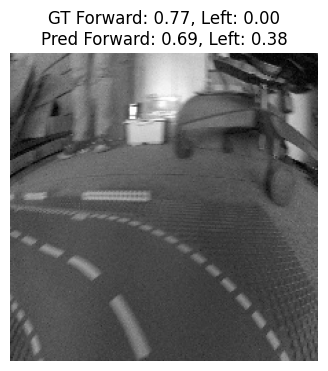

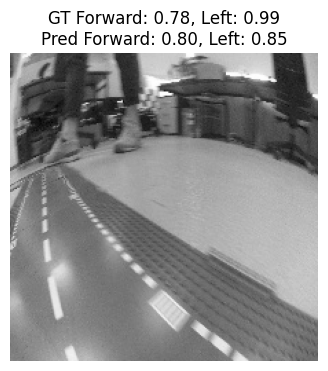

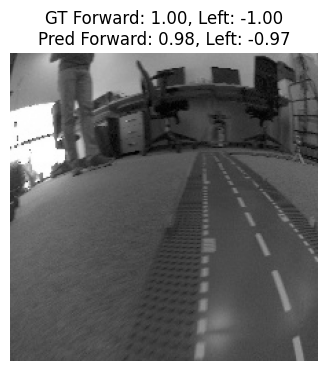

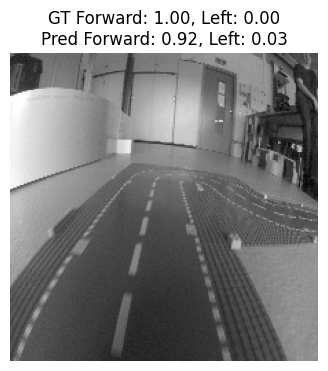

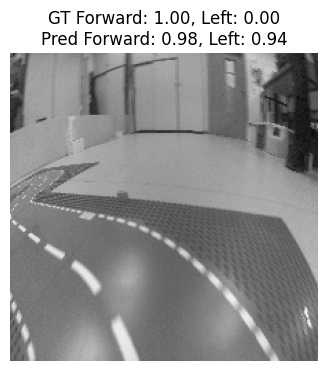

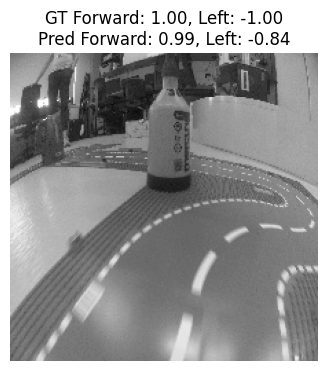

Average inference time per image: 0.000048 s
Approximate FPS: 20759.71


In [ ]:
import time
import matplotlib.pyplot as plt

def evaluate_and_display(model, dataloader, device, num_samples=5):
    model.eval()
    model.to(device)

    total_time = 0.0
    count = 0

    samples = []
    with torch.no_grad():
        for imgs, targets in dataloader:
            batch_size = imgs.size(0)
            imgs = imgs.to(device)
            targets = targets.to(device)

            start = time.perf_counter()
            outputs = model(imgs)
            end = time.perf_counter()

            elapsed = end - start
            total_time += elapsed
            count += batch_size

            imgs_cpu = imgs.cpu()
            targets_cpu = targets.cpu()
            outputs_cpu = outputs.cpu()

            for i in range(batch_size):
                if len(samples) >= num_samples:
                    break
                samples.append((imgs_cpu[i], targets_cpu[i], outputs_cpu[i]))

            if len(samples) >= num_samples:
                break

    avg_time = total_time / count
    fps = 1.0 / avg_time if avg_time > 0 else float('inf')

    for img, target, output in samples:
        img_np = img.squeeze().numpy()

        plt.figure(figsize=(4, 4))
        if img_np.ndim == 2:
            plt.imshow(img_np, cmap='gray')
        else:
            plt.imshow(img_np.transpose(1, 2, 0))
        plt.axis('off')

        fwd_gt, left_gt = target[0].item(), target[1].item()
        fwd_pred, left_pred = output[0].item(), output[1].item()

        title = (
            f"GT Forward: {fwd_gt:.2f}, Left: {left_gt:.2f}\n"
            f"Pred Forward: {fwd_pred:.2f}, Left: {left_pred:.2f}"
        )
        plt.title(title)
        plt.show()

    print(f"Average inference time per image: {avg_time:.6f} s")
    print(f"Approximate FPS: {fps:.2f}")

    return avg_time, fps



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
avg_time, fps = evaluate_and_display(model, val_loader, device, num_samples=6)